# Experiments with Similarity Encoders
## ...to show that SimEc can create similarity preserving embeddings based on human ratings
In this iPython Notebook are some examples to illustrate the potential of Similarity Encoders (SimEc) for creating similarity preserving embeddings. For further details and theoretical background on this new neural network architecture, please refer to the corresponding paper.

In [1]:
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range
import numpy as np
np.random.seed(28)
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import load_digits, fetch_mldata, fetch_20newsgroups
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
tf.set_random_seed(28)
import keras

# find nlputils at https://github.com/cod3licious/nlputils
from nlputils.features import FeatureTransform, features2mat

from simec import SimilarityEncoder
from utils import center_K, check_similarity_match
from utils_plotting import get_colors, plot_digits, plot_mnist, plot_20news

%matplotlib inline
%load_ext autoreload
%autoreload 2
# set this to True if you want to save the figures from the paper
savefigs = False

Using TensorFlow backend.


## Handwritten Digits (8x8 px)
See `http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html`

In [2]:
# load digits dataset
digits = load_digits()
X = digits.data
X /= float(X.max())
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
y = digits.target
n_samples, n_features = X.shape

#### SimEc based on class labels
We've seen that SimEcs can reach the same solutions as traditional spectral methods such as kPCA and isomap. However, these methods have the limitation that you can only embed new data points if you can compute their kernel map, i.e. the similarity to the training examples. But what if the similarity matrix used as targets during training was generated by an unknown process such as human similarity judgments?

To show how we can use SimEc in such a scenario, we construct the similarity matrix from the class labels assigned by human annotators (1=same class, 0=different class).

In [3]:
Y = np.tile(y, (len(y), 1))
S = center_K(np.array(Y==Y.T, dtype=int))
# take only some of the samples as targets to speed it all up
n_targets = 1000

In [4]:
# knn accuracy using all original feature dimensions
clf = KNN(n_neighbors=10)
clf.fit(X[:n_targets], y[:n_targets])
print("knn accuracy: %f" % clf.score(X[n_targets:], y[n_targets:]))

knn accuracy: 0.956085


knn accuracy: 0.608532


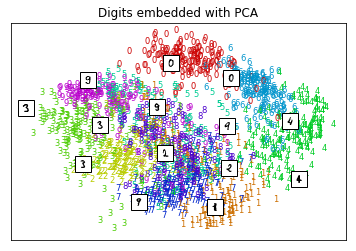

In [5]:
# PCA
pca = PCA(n_components=2)
X_embedp = pca.fit_transform(X)
plot_digits(X_embedp, digits, title='Digits embedded with PCA')
clf = KNN(n_neighbors=10)
clf.fit(X_embedp[:n_targets], y[:n_targets])
print("knn accuracy: %f" % clf.score(X_embedp[n_targets:], y[n_targets:]))

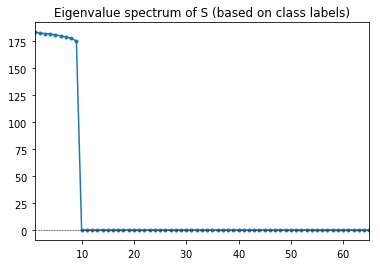

In [6]:
# check how many relevant dimensions there are
eigenvals = np.linalg.eigvalsh(S)[::-1]
plt.figure();
plt.plot(list(range(1, S.shape[0]+1)), eigenvals, '-o', markersize=3);
plt.plot([1, S.shape[0]],[0,0], 'k--', linewidth=0.5);
plt.xlim(1, X.shape[1]+1);
plt.title('Eigenvalue spectrum of S (based on class labels)');

knn accuracy: 1.000000
similarity approximation - mse: 0.069408


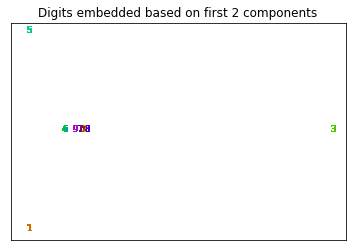

In [7]:
D, V = np.linalg.eig(S)
# regular kpca embedding: take largest EV
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V1.real, np.diag(np.sqrt(np.abs(D1.real))))
plot_digits(X_embed[:,:2], digits, title='Digits embedded based on first 2 components', plot_box=False)
clf = KNN(n_neighbors=10)
clf.fit(X_embed[:n_targets,:2], y[:n_targets])
print("knn accuracy: %f" % clf.score(X_embed[n_targets:,:2], y[n_targets:]))
print("similarity approximation - mse: %f" % check_similarity_match(X_embed[:,:2], S)[0])

Lets first try a simple linear SimEc.

Epoch 1/25
1797/1797 [==============================] - 1s 386us/step - loss: 0.1301
Epoch 2/25
1797/1797 [==============================] - 0s 92us/step - loss: 0.1203
Epoch 3/25
1797/1797 [==============================] - 0s 99us/step - loss: 0.1175
Epoch 4/25
1797/1797 [==============================] - 0s 84us/step - loss: 0.1163
Epoch 5/25
1797/1797 [==============================] - 0s 84us/step - loss: 0.1151
Epoch 6/25
1797/1797 [==============================] - 0s 85us/step - loss: 0.1141
Epoch 7/25
1797/1797 [==============================] - 0s 91us/step - loss: 0.1129
Epoch 8/25
1797/1797 [==============================] - 0s 89us/step - loss: 0.1118
Epoch 9/25
1797/1797 [==============================] - 0s 100us/step - loss: 0.1109
Epoch 10/25
1797/1797 [==============================] - 0s 93us/step - loss: 0.1102
Epoch 11/25
1797/1797 [==============================] - 0s 95us/step - loss: 0.1097
Epoch 12/25
1797/1797 [==============================] - 0s 100us/step -

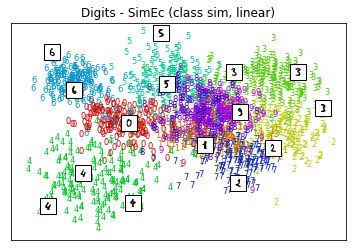

In [8]:
# similarity encoder with similarities relying on class information - linear
simec = SimilarityEncoder(X.shape[1], 2, n_targets, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                          s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.005))
simec.fit(X, S[:,:n_targets])
X_embed = simec.transform(X)
plot_digits(X_embed, digits, title='Digits - SimEc (class sim, linear)')
# of course we're overfitting here quite a bit since we used all samples for training
# even if we didn't use the corresponding similarities...but this is only a toy example anyways
clf = KNN(n_neighbors=10)
clf.fit(X_embed[:n_targets], y[:n_targets])
print("knn accuracy: %f" % clf.score(X_embed[n_targets:], y[n_targets:]))
print("similarity approximation - mse: %f" % check_similarity_match(X_embed, S)[0])

Great, we already see some clusters separating from the rest! What if we add more layers?

We can examine how the embedding changes during training: first some clusters separate, then it starts to look like the eigenvalue based embedding with the clusters of several numbers pulled together.

5
Epoch 1/5
1797/1797 [==============================] - 0s 185us/step - loss: 0.1232
Epoch 2/5
1797/1797 [==============================] - 0s 113us/step - loss: 0.1172
Epoch 3/5
1797/1797 [==============================] - 0s 114us/step - loss: 0.1161
Epoch 4/5
1797/1797 [==============================] - 0s 111us/step - loss: 0.1147
Epoch 5/5
1797/1797 [==============================] - 0s 102us/step - loss: 0.1129
knn accuracy: 0.670013
similarity approximation - mse: 0.114144
15
Epoch 1/10
1797/1797 [==============================] - 0s 116us/step - loss: 0.1109
Epoch 2/10
1797/1797 [==============================] - 0s 111us/step - loss: 0.1092
Epoch 3/10
1797/1797 [==============================] - 0s 102us/step - loss: 0.1081
Epoch 4/10
1797/1797 [==============================] - 0s 102us/step - loss: 0.1076
Epoch 5/10
1797/1797 [==============================] - 0s 104us/step - loss: 0.1073
Epoch 6/10
1797/1797 [==============================] - 0s 107us/step - loss: 0.1071
E

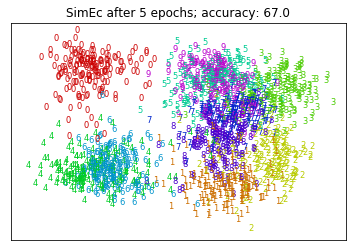

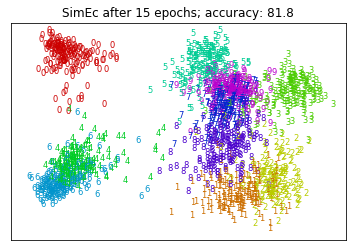

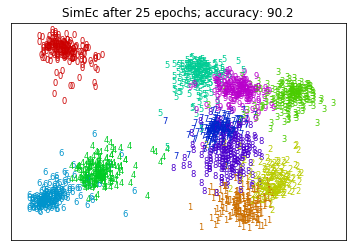

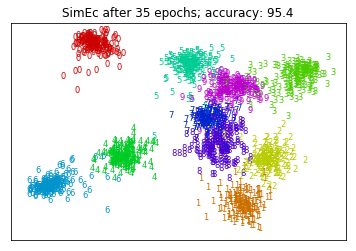

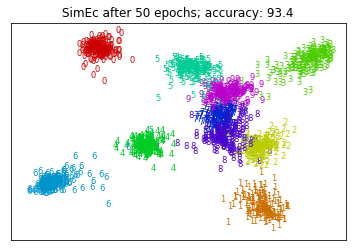

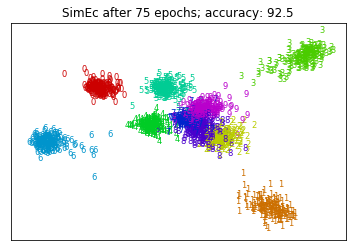

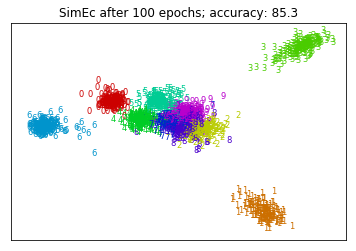

In [9]:
# similarity encoder with similarities relying on class information - 1 hidden layer
n_targets = 1000
simec = SimilarityEncoder(X.shape[1], 2, n_targets, hidden_layers=[(100, 'tanh')], 
                          l2_reg=0.00000001, l2_reg_emb=0.00001, l2_reg_out=0.0000001, 
                          s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets], opt=keras.optimizers.Adamax(lr=0.01))
e_total = 0
for e in [5, 10, 10, 10, 15, 25, 25]:
    e_total += e
    print(e_total)
    simec.fit(X, S[:,:n_targets], epochs=e)
    X_embed = simec.transform(X)
    clf = KNN(n_neighbors=10)
    clf.fit(X_embed[:1000], y[:1000])
    acc = clf.score(X_embed[1000:], y[1000:])
    print("knn accuracy: %f" % acc)
    print("similarity approximation - mse: %f" % check_similarity_match(X_embed, S)[0])
    plot_digits(X_embed, digits, title='SimEc after %i epochs; accuracy: %.1f' % (e_total, 100*acc) , plot_box=False)

## MNIST Dataset
Embedding the regular 28x28 pixel MNIST digits

In [10]:
# load digits
mnist = fetch_mldata('MNIST original', data_home='data')
X = mnist.data/255.  # normalize to 0-1
y = np.array(mnist.target, dtype=int)
# subsample 10000 random data points
np.random.seed(42)
n_samples = 10000
n_test = 2000
n_targets = 1000
rnd_idx = np.random.permutation(X.shape[0])[:n_samples]
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]
# scale
ss = StandardScaler(with_std=False)
X = ss.fit_transform(X)
X_test = ss.transform(X_test)
n_train, n_features = X.shape

In [11]:
# compute similarity matrix based on class labels
Y = np.tile(y, (len(y), 1))
S = center_K(np.array(Y==Y.T, dtype=int))
Y = np.tile(y_test, (len(y_test), 1))
S_test = center_K(np.array(Y==Y.T, dtype=int))

#### "Kernel PCA" and Ridge Regression vs. SimEc
To get an idea of how a perfect similarity preserving embedding would look like when computing similarities from class labels, we can embed the data by performing an eigendecomposition of the similarity matrix (i.e. performing kernel PCA). However, since in a real setting we would be unable to compute the similarities of the test samples to the training samples (since we don't know their class labels), to map the test samples into the embedding space we additionally need to train a (ridge) regression model to map from the original input space to the embedding space.

A SimEc with multiple hidden layers starts to get close to the eigendecomposition solution.

similarity approximation  2D - mse: 0.066420
similarity approximation  5D - mse: 0.035617
similarity approximation  7D - mse: 0.016659
similarity approximation 10D - mse: 0.000000
similarity approximation 25D - mse: 0.000000


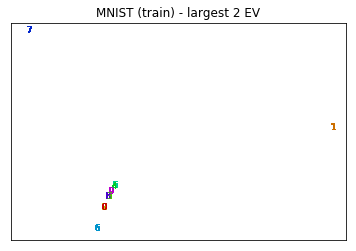

In [12]:
D, V = np.linalg.eig(S)
# as a comparison: regular kpca embedding: take largest EV
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V1.real, np.diag(np.sqrt(np.abs(D1.real))))
plot_mnist(X_embed[:,:2], y, title='MNIST (train) - largest 2 EV')
print("similarity approximation  2D - mse: %f" % check_similarity_match(X_embed[:,:2], S)[0])
print("similarity approximation  5D - mse: %f" % check_similarity_match(X_embed[:,:5], S)[0])
print("similarity approximation  7D - mse: %f" % check_similarity_match(X_embed[:,:7], S)[0])
print("similarity approximation 10D - mse: %f" % check_similarity_match(X_embed[:,:10], S)[0])
print("similarity approximation 25D - mse: %f" % check_similarity_match(X_embed[:,:25], S)[0])

Ridge Regression with alpha: 75.0
2
Epoch 1/25
8000/8000 [==============================] - 1s 176us/step - loss: 0.1282
Epoch 2/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.1199
Epoch 3/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.1188
Epoch 4/25
8000/8000 [==============================] - 1s 141us/step - loss: 0.1182
Epoch 5/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.1177
Epoch 6/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.1173
Epoch 7/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.1168
Epoch 8/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.1163
Epoch 9/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.1157
Epoch 10/25
8000/8000 [==============================] - 1s 140us/step - loss: 0.1150
Epoch 11/25
8000/8000 [==============================] - 1s 138us/step - loss: 0.1140
Epoch 12/25
8000/8000 [====

8000/8000 [==============================] - 1s 167us/step - loss: 0.0696
Epoch 12/25
8000/8000 [==============================] - 1s 166us/step - loss: 0.0669
Epoch 13/25
8000/8000 [==============================] - 1s 167us/step - loss: 0.0654
Epoch 14/25
8000/8000 [==============================] - 1s 165us/step - loss: 0.0646
Epoch 15/25
8000/8000 [==============================] - 1s 164us/step - loss: 0.0639
Epoch 16/25
8000/8000 [==============================] - 1s 166us/step - loss: 0.0631
Epoch 17/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0622
Epoch 18/25
8000/8000 [==============================] - 1s 167us/step - loss: 0.0611
Epoch 19/25
8000/8000 [==============================] - 1s 165us/step - loss: 0.0599
Epoch 20/25
8000/8000 [==============================] - 1s 167us/step - loss: 0.0590
Epoch 21/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0583
Epoch 22/25
8000/8000 [==============================] - 1s 169us/

8000/8000 [==============================] - 1s 146us/step - loss: 0.0378
Epoch 21/25
8000/8000 [==============================] - 1s 143us/step - loss: 0.0377
Epoch 22/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.0376
Epoch 23/25
8000/8000 [==============================] - 1s 148us/step - loss: 0.0375
Epoch 24/25
8000/8000 [==============================] - 1s 142us/step - loss: 0.0373
Epoch 25/25
8000/8000 [==============================] - 1s 146us/step - loss: 0.0373
Epoch 1/25
8000/8000 [==============================] - 2s 244us/step - loss: 0.1133
Epoch 2/25
8000/8000 [==============================] - 1s 171us/step - loss: 0.0924
Epoch 3/25
8000/8000 [==============================] - 1s 165us/step - loss: 0.0853
Epoch 4/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0788
Epoch 5/25
8000/8000 [==============================] - 1s 170us/step - loss: 0.0734
Epoch 6/25
8000/8000 [==============================] - 1s 173us/step -

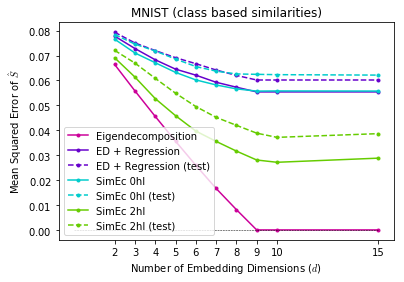

In [13]:
n_targets = 2000
# get good alpha for RR model
m = Ridge()
rrm = GridSearchCV(m, {'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1., 2.5, 5., 7.5, 10., 25., 50., 75., 100., 250., 500., 750., 1000.]})
rrm.fit(X, X_embed[:,:8])
alpha = rrm.best_params_["alpha"]
print("Ridge Regression with alpha: %r" % alpha)
mse_ev, mse_rr, mse_rr_test = [], [], []
mse_simec, mse_simec_test = [], []
mse_simec_hl, mse_simec_hl_test = [], []
e_dims = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
for e_dim in e_dims:
    print(e_dim)
    # eigenvalue based embedding
    mse = check_similarity_match(X_embed[:,:e_dim], S)[0]
    mse_ev.append(mse)
    # train a linear ridge regression model to learn the mapping from X to Y
    model = Ridge(alpha=alpha)
    model.fit(X, X_embed[:,:e_dim])
    X_embed_r = model.predict(X)
    X_embed_test_r = model.predict(X_test)
    mse = check_similarity_match(X_embed_r, S)[0]
    mse_rr.append(mse)
    mse = check_similarity_match(X_embed_test_r, S_test)[0]
    mse_rr_test.append(mse)
    # simec - linear
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets],
                              orth_reg=0.001 if e_dim > 8 else 0., l2_reg_emb=0.00001, 
                              l2_reg_out=0.0000001, opt=keras.optimizers.Adamax(lr=0.001))
    simec.fit(X, S[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse = check_similarity_match(X_embeds, S)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_tests, S_test)[0]
    mse_simec_test.append(mse_t)
    # simec - 2hl
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(25, 'tanh'), (25, 'tanh')],
                              s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets], orth_reg=0.001 if e_dim > 7 else 0., 
                              l2_reg=0., l2_reg_emb=0.00001, l2_reg_out=0.0000001, opt=keras.optimizers.Adamax(lr=0.001))
    simec.fit(X, S[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse = check_similarity_match(X_embeds, S)[0]
    mse_simec_hl.append(mse)
    mse_t = check_similarity_match(X_embed_tests, S_test)[0]
    mse_simec_hl_test.append(mse_t)
    print("mse ev: %f; mse rr: %f (%f); mse simec (0hl): %f (%f); mse simec (2hl): %f (%f)" % (mse_ev[-1], mse_rr[-1], mse_rr_test[-1], mse_simec[-1], mse_simec_test[-1], mse, mse_t))
keras.backend.clear_session()
colors = get_colors(15)
plt.figure();
plt.plot(e_dims, mse_ev, '-o', markersize=3, c=colors[14], label='Eigendecomposition');
plt.plot(e_dims, mse_rr, '-o', markersize=3, c=colors[12], label='ED + Regression');
plt.plot(e_dims, mse_rr_test, '--o', markersize=3, c=colors[12], label='ED + Regression (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc 0hl');
plt.plot(e_dims, mse_simec_test, '--o', markersize=3, c=colors[8], label='SimEc 0hl (test)');
plt.plot(e_dims, mse_simec_hl, '-o', markersize=3, c=colors[4], label='SimEc 2hl');
plt.plot(e_dims, mse_simec_hl_test, '--o', markersize=3, c=colors[4], label='SimEc 2hl (test)');
plt.legend(loc=0);
plt.title('MNIST (class based similarities)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print("e_dims=", e_dims)
print("mse_ev=", mse_ev)
print("mse_rr=", mse_rr)
print("mse_rr_test=", mse_rr_test)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
print("mse_simec_hl=", mse_simec_hl)
print("mse_simec_hl_test=", mse_simec_hl_test)
if savefigs: plt.savefig('fig_class_mse_edim.pdf', dpi=300)

## 20 Newsgroups
To show that SimEc embeddings can also be computed for other types of data, we do some further experiments with the 20 newsgroups dataset. We subsample 7 of the 20 categories and remove meta information such as headers to avoid overfitting (see also `http://scikit-learn.org/stable/datasets/twenty_newsgroups.html`). The posts are transformed into very high dimensional tf-idf vectors used as input to the SimEc and to compute the linear kernel matrix.

In [14]:
## load the data and transform it into a tf-idf representation
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
# store in dicts (if the text contains more than 3 words)
textdict = {i: t for i, t in enumerate(newsgroups_train.data) if len(t.split()) > 3}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data)) if len(t.split()) > 3})
train_ids = [i for i in range(len(newsgroups_train.data)) if i in textdict]
test_ids = [i for i in range(len(newsgroups_train.data), len(textdict)) if i in textdict]
print("%i training and %i test samples" % (len(train_ids), len(test_ids)))
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# organize in feature matrix
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print("%i features" % len(featurenames))
targets = np.hstack([newsgroups_train.target,newsgroups_test.target])
y = targets[train_ids]
y_test = targets[test_ids]
n_targets = 1000
target_names = newsgroups_train.target_names

3959 training and 2359 test samples
45813 features


similarity approximation  2D - mse: 0.079464
similarity approximation  5D - mse: 0.018388
similarity approximation  7D - mse: 0.000000
similarity approximation 10D - mse: 0.000000
similarity approximation 25D - mse: 0.000000


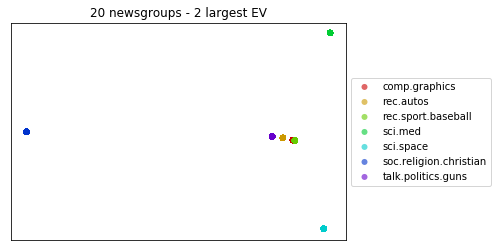

In [15]:
# compute label based simmat
Y = np.tile(y, (len(y), 1))
S = center_K(np.array(Y==Y.T, dtype=int))
Y = np.tile(y_test, (len(y_test), 1))
S_test = center_K(np.array(Y==Y.T, dtype=int))
D, V = np.linalg.eig(S)
# as a comparison: regular kpca embedding: take largest EV
D1, V1 = D[np.argsort(D)[::-1]], V[:,np.argsort(D)[::-1]]
X_embed = np.dot(V1.real, np.diag(np.sqrt(np.abs(D1.real))))
plot_20news(X_embed[:, :2], y, target_names, title='20 newsgroups - 2 largest EV', legend=True)
print("similarity approximation  2D - mse: %f" % check_similarity_match(X_embed[:,:2], S)[0])
print("similarity approximation  5D - mse: %f" % check_similarity_match(X_embed[:,:5], S)[0])
print("similarity approximation  7D - mse: %f" % check_similarity_match(X_embed[:,:7], S)[0])
print("similarity approximation 10D - mse: %f" % check_similarity_match(X_embed[:,:10], S)[0])
print("similarity approximation 25D - mse: %f" % check_similarity_match(X_embed[:,:25], S)[0])

Ridge Regression with alpha: 2.5
2
Epoch 1/25
3959/3959 [==============================] - 3s 642us/step - loss: 0.1624
Epoch 2/25
3959/3959 [==============================] - 1s 193us/step - loss: 0.1421
Epoch 3/25
3959/3959 [==============================] - 1s 189us/step - loss: 0.1386
Epoch 4/25
3959/3959 [==============================] - 1s 195us/step - loss: 0.1373
Epoch 5/25
3959/3959 [==============================] - 1s 194us/step - loss: 0.1367
Epoch 6/25
3959/3959 [==============================] - 1s 198us/step - loss: 0.1363
Epoch 7/25
3959/3959 [==============================] - 1s 200us/step - loss: 0.1362
Epoch 8/25
3959/3959 [==============================] - 1s 197us/step - loss: 0.1360
Epoch 9/25
3959/3959 [==============================] - 1s 188us/step - loss: 0.1359
Epoch 10/25
3959/3959 [==============================] - 1s 197us/step - loss: 0.1358
Epoch 11/25
3959/3959 [==============================] - 1s 192us/step - loss: 0.1357
Epoch 12/25
3959/3959 [=====

3959/3959 [==============================] - 1s 238us/step - loss: 0.0553
Epoch 12/25
3959/3959 [==============================] - 1s 239us/step - loss: 0.0552
Epoch 13/25
3959/3959 [==============================] - 1s 237us/step - loss: 0.0551
Epoch 14/25
3959/3959 [==============================] - 1s 240us/step - loss: 0.0551
Epoch 15/25
3959/3959 [==============================] - 1s 241us/step - loss: 0.0550
Epoch 16/25
3959/3959 [==============================] - 1s 240us/step - loss: 0.0550
Epoch 17/25
3959/3959 [==============================] - 1s 239us/step - loss: 0.0550
Epoch 18/25
3959/3959 [==============================] - 1s 238us/step - loss: 0.0549
Epoch 19/25
3959/3959 [==============================] - 1s 234us/step - loss: 0.0549
Epoch 20/25
3959/3959 [==============================] - 1s 234us/step - loss: 0.0549
Epoch 21/25
3959/3959 [==============================] - 1s 239us/step - loss: 0.0549
Epoch 22/25
3959/3959 [==============================] - 1s 242us/

3959/3959 [==============================] - 1s 197us/step - loss: 0.0463
Epoch 21/25
3959/3959 [==============================] - 1s 200us/step - loss: 0.0455
Epoch 22/25
3959/3959 [==============================] - 1s 198us/step - loss: 0.0449
Epoch 23/25
3959/3959 [==============================] - 1s 202us/step - loss: 0.0444
Epoch 24/25
3959/3959 [==============================] - 1s 198us/step - loss: 0.0440
Epoch 25/25
3959/3959 [==============================] - 1s 205us/step - loss: 0.0436
Epoch 1/25
3959/3959 [==============================] - 3s 783us/step - loss: 0.2149
Epoch 2/25
3959/3959 [==============================] - 1s 247us/step - loss: 0.0875
Epoch 3/25
3959/3959 [==============================] - 1s 242us/step - loss: 0.0403
Epoch 4/25
3959/3959 [==============================] - 1s 238us/step - loss: 0.0281
Epoch 5/25
3959/3959 [==============================] - 1s 249us/step - loss: 0.0242
Epoch 6/25
3959/3959 [==============================] - 1s 242us/step -

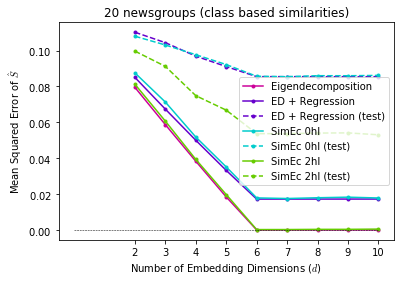

In [16]:
n_targets = 2000
# get good alpha for RR model
m = Ridge()
rrm = GridSearchCV(m, {'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1., 2.5, 5., 7.5, 10., 25., 50., 75., 100., 250., 500., 750., 1000.]})
rrm.fit(X, X_embed[:,:8])
alpha = rrm.best_params_["alpha"]
print("Ridge Regression with alpha: %r" % alpha)
mse_ev, mse_rr, mse_rr_test = [], [], []
mse_simec, mse_simec_test = [], []
mse_simec_hl, mse_simec_hl_test = [], []
e_dims = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for e_dim in e_dims:
    print(e_dim)
    # eigenvalue based embedding
    mse = check_similarity_match(X_embed[:,:e_dim], S)[0]
    mse_ev.append(mse)
    # train a linear ridge regression model to learn the mapping from X to Y
    model = Ridge(alpha=alpha)
    model.fit(X, X_embed[:,:e_dim])
    X_embed_r = model.predict(X)
    X_embed_test_r = model.predict(X_test)
    mse = check_similarity_match(X_embed_r, S)[0]
    mse_rr.append(mse)
    mse = check_similarity_match(X_embed_test_r, S_test)[0]
    mse_rr_test.append(mse)
    # simec - linear
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, s_ll_reg=0.5, S_ll=S[:n_targets,:n_targets],
                              sparse_inputs=True, orth_reg=0.1 if e_dim > 6 else 0., l2_reg_emb=0.0001, 
                              l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.01))
    simec.fit(X, S[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse = check_similarity_match(X_embeds, S)[0]
    mse_simec.append(mse)
    mse_t = check_similarity_match(X_embed_tests, S_test)[0]
    mse_simec_test.append(mse_t)
    # simec - 2hl
    simec = SimilarityEncoder(X.shape[1], e_dim, n_targets, hidden_layers=[(25, 'tanh'), (25, 'tanh')], sparse_inputs=True,
                              s_ll_reg=1., S_ll=S[:n_targets,:n_targets], orth_reg=0.1 if e_dim > 7 else 0., 
                              l2_reg=0., l2_reg_emb=0.01, l2_reg_out=0.00001, opt=keras.optimizers.Adamax(lr=0.01))
    simec.fit(X, S[:,:n_targets])
    X_embeds = simec.transform(X)
    X_embed_tests = simec.transform(X_test)
    mse = check_similarity_match(X_embeds, S)[0]
    mse_simec_hl.append(mse)
    mse_t = check_similarity_match(X_embed_tests, S_test)[0]
    mse_simec_hl_test.append(mse_t)
    print("mse ev: %f; mse rr: %f (%f); mse simec (0hl): %f (%f); mse simec (2hl): %f (%f)" % (mse_ev[-1], mse_rr[-1], mse_rr_test[-1], mse_simec[-1], mse_simec_test[-1], mse, mse_t))
keras.backend.clear_session()
colors = get_colors(15)
plt.figure();
plt.plot(e_dims, mse_ev, '-o', markersize=3, c=colors[14], label='Eigendecomposition');
plt.plot(e_dims, mse_rr, '-o', markersize=3, c=colors[12], label='ED + Regression');
plt.plot(e_dims, mse_rr_test, '--o', markersize=3, c=colors[12], label='ED + Regression (test)');
plt.plot(e_dims, mse_simec, '-o', markersize=3, c=colors[8], label='SimEc 0hl');
plt.plot(e_dims, mse_simec_test, '--o', markersize=3, c=colors[8], label='SimEc 0hl (test)');
plt.plot(e_dims, mse_simec_hl, '-o', markersize=3, c=colors[4], label='SimEc 2hl');
plt.plot(e_dims, mse_simec_hl_test, '--o', markersize=3, c=colors[4], label='SimEc 2hl (test)');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);
plt.title('20 newsgroups (class based similarities)');
plt.plot([0, e_dims[-1]], [0,0], 'k--', linewidth=0.5);
plt.xticks(e_dims, e_dims);
plt.xlabel('Number of Embedding Dimensions ($d$)')
plt.ylabel('Mean Squared Error of $\hat{S}$')
print("e_dims=", e_dims)
print("mse_ev=", mse_ev)
print("mse_rr=", mse_rr)
print("mse_rr_test=", mse_rr_test)
print("mse_simec=", mse_simec)
print("mse_simec_test=", mse_simec_test)
print("mse_simec_hl=", mse_simec_hl)
print("mse_simec_hl_test=", mse_simec_hl_test)